In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

<h1>Loading in the data</h1>

In [2]:
#Load in fighters as nodes
nodes = pd.read_csv('nodes.csv')
most_common_value = nodes['STANCE'].value_counts().idxmax()
nodes['STANCE'].fillna(most_common_value, inplace=True)
nodes['FIGHTER'] = nodes['FIGHTER'].str.strip()
nodes

,FIGHTER,HEIGHT,WEIGHT,REACH,STANCE,DOB,SLpM,Str. Acc,SApM,Str. Def,TD Avg,TD Acc,TD Def,Sub. Avg
0,Tom Aaron,--,155 lbs.,--,Orthodox,"Jul 13, 1978",0.00,0%,0.00,0%,0.00,0%,0%,0.0
1,Danny Abbadi,"5' 11""",155 lbs.,--,Orthodox,"Jul 03, 1983",3.29,38%,4.41,57%,0.00,0%,77%,0.0
2,Nariman Abbasov,"5' 8""",155 lbs.,"66""",Orthodox,"Feb 01, 1994",3.00,20%,5.67,46%,0.00,0%,66%,0.0
3,David Abbott,"6' 0""",265 lbs.,--,Switch,--,1.35,30%,3.55,38%,1.07,33%,66%,0.0
4,Hamdy Abdelwahab,"6' 2""",264 lbs.,"72""",Southpaw,"Jan 22, 1993",3.87,52%,3.13,59%,3.00,75%,0%,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4025,Dave Zitanick,--,170 lbs.,--,Orthodox,"Mar 05, 1980",0.00,0%,0.00,0%,0.00,0%,0%,0.0
4026,Alex Zuniga,--,145 lbs.,--,Orthodox,--,0.00,0%,0.00,0%,0.00,0%,0%,0.0
4027,George Zuniga,"5' 9""",185 lbs.,--,Orthodox,--,7.64,38%,5.45,37%,0.00,0%,100%,0.0
4028,Allan Zuniga,"5' 7""",155 lbs.,"70""",Orthodox,"Apr 04, 1992",3.93,52%,1.80,61%,0.00,0%,57%,1.0


In [3]:
#Load in fights as edges
edges = pd.read_csv('edges.csv')
edges.rename(columns={'FIGHERT1': 'FIGHTER1', 'FIGHERT2': 'FIGHTER2'}, inplace=True)
edges['FIGHTER1'], edges['FIGHTER2'] = np.where(edges['OUTCOME1'] == 'L', edges['FIGHTER2'], edges['FIGHTER1']), np.where(edges['OUTCOME1'] == 'L', edges['FIGHTER1'], edges['FIGHTER2'])
edges = edges.drop(edges[(edges['OUTCOME1'] == 'NC') | (edges['OUTCOME1'] == 'D') | (edges['OUTCOME2'] == 'NC') | (edges['OUTCOME2'] == 'D')].index)
edges = edges.drop(columns= ['OUTCOME1','OUTCOME2'])
most_common_value = edges['REFEREE'].value_counts().idxmax()
edges['REFEREE'].fillna(most_common_value, inplace=True)
edges['FIGHTER1'] = edges['FIGHTER1'].str.strip()
edges['FIGHTER2'] = edges['FIGHTER2'].str.strip()
edges

,FIGHTER1,FIGHTER2,METHOD,ROUND,TIME,REFEREE,DATE
0,Amir Albazi,Kai Kara-France,Decision - Split,5,5:00,Herb Dean,"June 03, 2023"
1,Alex Caceres,Daniel Pineda,Decision - Unanimous,3,5:00,Mark Smith,"June 03, 2023"
2,Jim Miller,Jesse Butler,KO/TKO,1,0:23,Dan Miragliotta,"June 03, 2023"
3,Tim Elliott,Victor Altamirano,Decision - Unanimous,3,5:00,Mark Smith,"June 03, 2023"
4,Karine Silva,Ketlen Souza,Submission,1,1:45,Chris Tognoni,"June 03, 2023"
...,...,...,...,...,...,...,...
7151,Orlando Wiet,Robert Lucarelli,KO/TKO,1,2:50,John McCarthy,"March 11, 1994"
7152,Frank Hamaker,Thaddeus Luster,Submission,1,4:52,John McCarthy,"March 11, 1994"
7153,Johnny Rhodes,David Levicki,KO/TKO,1,12:13,John McCarthy,"March 11, 1994"
7154,Patrick Smith,Ray Wizard,Submission,1,0:58,John McCarthy,"March 11, 1994"


In [4]:
#just keep who fought who as edges
edges1 = edges[['FIGHTER1', 'FIGHTER2']]
edges1

,FIGHTER1,FIGHTER2
0,Amir Albazi,Kai Kara-France
1,Alex Caceres,Daniel Pineda
2,Jim Miller,Jesse Butler
3,Tim Elliott,Victor Altamirano
4,Karine Silva,Ketlen Souza
...,...,...
7151,Orlando Wiet,Robert Lucarelli
7152,Frank Hamaker,Thaddeus Luster
7153,Johnny Rhodes,David Levicki
7154,Patrick Smith,Ray Wizard


In [5]:
#Calculate the overall fights, wins and win percentage

# Create a boolean Series where each value is True if the fighter's name is in 'FIGHTER1' or 'FIGHTER2', False otherwise
nodes1 = nodes['FIGHTER'].to_frame()
in_edges1 = nodes1['FIGHTER'].isin(pd.concat([edges1['FIGHTER1'], edges1['FIGHTER2']]))
nodes1 = nodes['FIGHTER'].to_frame()
# Keep only the rows in 'nodes' where 'FIGHTER' is in 'edges1'
nodes1 = nodes1[in_edges1]

overall = pd.concat([edges1['FIGHTER1'], edges1['FIGHTER2']]).value_counts()
wins = edges1['FIGHTER1'].value_counts()

# Now we'll create a new DataFrame from these Series
data = {'NAME': overall.index, 'OVERALL': overall.values, 'WINS': wins.reindex(overall.index, fill_value=0).values}
nodes1 = pd.DataFrame(data)
# Calculate win percentage
nodes1['WIN PERCENT'] = (nodes1['WINS'] / nodes1['OVERALL']) * 100
nodes1['WIN PERCENT'] = nodes1['WIN PERCENT'].fillna(0)
nodes1

,NAME,OVERALL,WINS,WIN PERCENT
0,Jim Miller,41,25,60.975610
1,Andrei Arlovski,39,23,58.974359
2,Donald Cerrone,37,23,62.162162
3,Clay Guida,35,18,51.428571
4,Rafael Dos Anjos,33,21,63.636364
...,...,...,...,...
2376,Marcin Wrzosek,1,0,0.000000
2377,Felipe Olivieri,1,0,0.000000
2378,Martin Svensson,1,0,0.000000
2379,Filip Pejic,1,0,0.000000


<h1>Creating networks</h1>

In [6]:
#Create subgraphs for female and male fighters
G = nx.from_pandas_edgelist(edges1, source='FIGHTER2', target='FIGHTER1', create_using=nx.DiGraph())
G_weakly_connected = list(nx.weakly_connected_components(G))
G_women = G.subgraph(G_weakly_connected[1])
G_men = G.subgraph(G_weakly_connected[0])

In [7]:
# Count the number of nodes
num_nodes_males = G_men.number_of_nodes()
num_nodes_females = G_women.number_of_nodes()
print("Number of nodes males:", num_nodes_males)
print("Number of nodes females:", num_nodes_females)

# Count the number of edges
num_edges_males = G_men.number_of_edges()
num_edges_females = G_women.number_of_edges()
print("Number of edges males:", num_edges_males)
print("Number of edges females:", num_edges_females)

Number of nodes males: 2113
Number of nodes females: 220
Number of edges males: 6248
Number of edges females: 655


<h1>Degree distribution and shortest path between champions</h1>

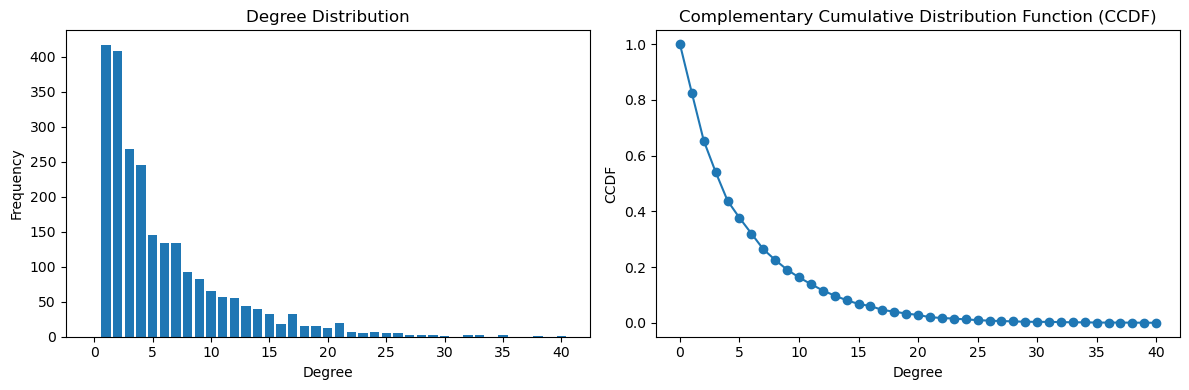

In [8]:
#plot Degree Distribution
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degree_count = nx.degree_histogram(G)
cumulative_count = np.cumsum(degree_count)
ccdf = 1 - cumulative_count / cumulative_count[-1]
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Degree distribution plot
ax[0].bar(range(len(degree_count)), degree_count)
ax[0].set_xlabel('Degree')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Degree Distribution')

# CCDF plot without logarithmic scale
ax[1].plot(range(len(ccdf)), ccdf, 'o-')
ax[1].set_xlabel('Degree')
ax[1].set_ylabel('CCDF')
ax[1].set_title('Complementary Cumulative Distribution Function (CCDF)')

plt.tight_layout()
plt.show()


In [9]:
#average degree Distribution
average_degree = sum(dict(G.degree()).values()) / len(G)
average_degree

5.819403611927761

In [10]:
avg_shortest_path_length = nx.average_shortest_path_length(G_women.to_undirected())
print("Average shortest path length women:", avg_shortest_path_length)

Average shortest path length women: 3.637027812370278


In [11]:
avg_shortest_path_length = nx.average_shortest_path_length(G_men.to_undirected())
print("Average shortest path length men:", avg_shortest_path_length)

Average shortest path length men: 5.565677479958124


Shortest path between Brandon Moreno and Jon Jones:
['Brandon Moreno', 'Brandon Royval', 'Tim Elliott', 'Tagir Ulanbekov', 'Bruno Silva', 'Wellington Turman', 'Sam Alvey', 'Rashad Evans', 'Thiago Silva', 'Matt Hamill', 'Jon Jones']


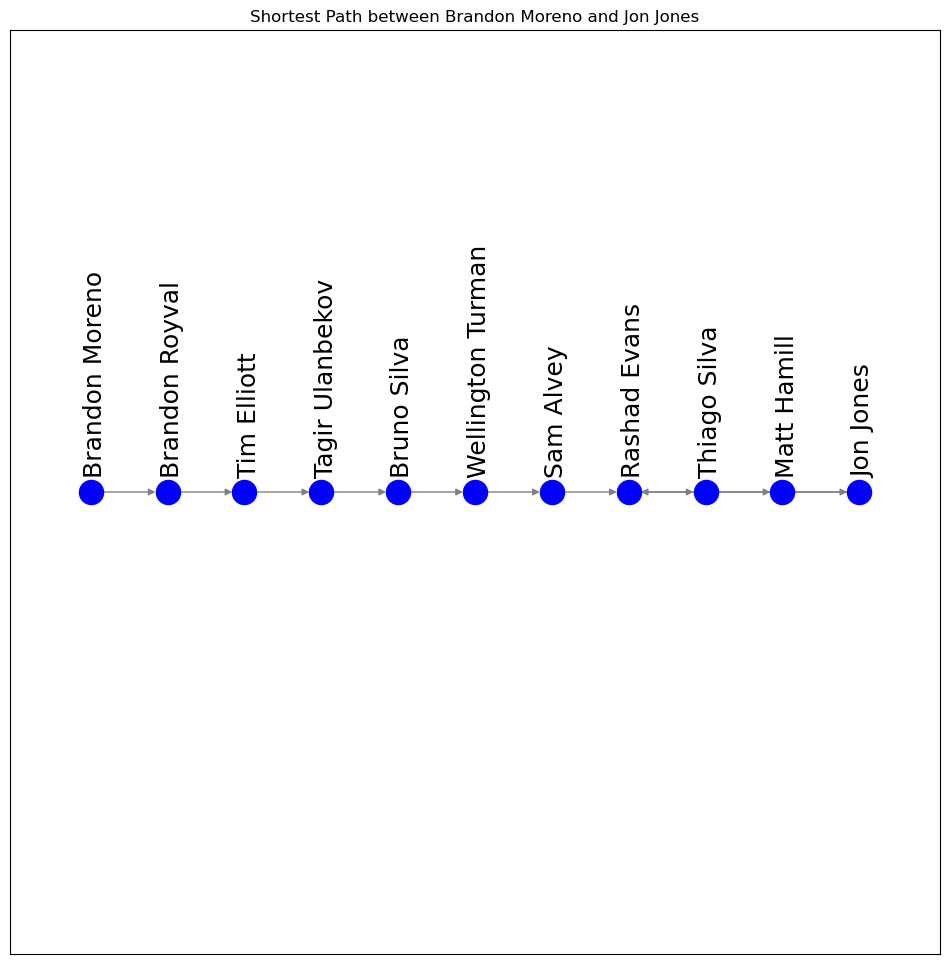

In [12]:
source_node = 'Brandon Moreno'
target_node = 'Jon Jones'

shortest_path = nx.shortest_path(G_men.reverse(), source=source_node, target=target_node)

print(f"Shortest path between {source_node} and {target_node}:")
print(shortest_path)

# Define the spacing between nodes
spacing = 4

# Generate a dict of positions placing nodes on a line
pos = {node: (index * spacing, 0) for index, node in enumerate(shortest_path)}
plt.figure(figsize=(12, 12))

# Create a subgraph that only contains the nodes in the shortest path
H = G_men.reverse().subgraph(shortest_path)

# Draw the subgraph
nx.draw_networkx(H, pos, with_labels=False, node_color='blue', edge_color='grey')

# Add labels rotated 90 degrees
for node, (x, y) in pos.items():
    plt.text(x-0.4, y+0.0001, node, rotation=90, fontsize=18)

plt.title(f"Shortest Path between {source_node} and {target_node}")
plt.show()

Shortest path between Zhang Weili and Amanda Nunes:
['Zhang Weili', 'Jessica Andrade', 'Raquel Pennington', 'Ketlen Vieira', 'Cat Zingano', 'Amanda Nunes']


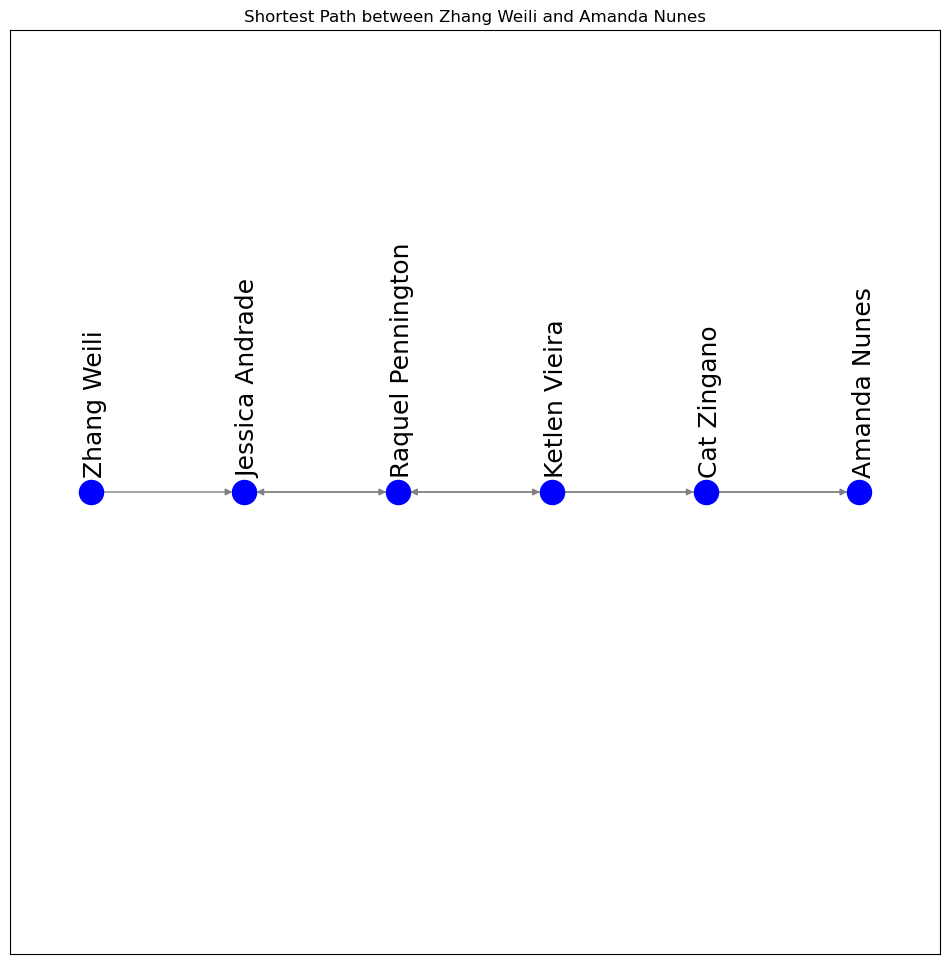

In [13]:
source_node = 'Zhang Weili'
target_node = 'Amanda Nunes'

shortest_path = nx.shortest_path(G_women.reverse(), source=source_node, target=target_node)

print(f"Shortest path between {source_node} and {target_node}:")
print(shortest_path)

# Define the spacing between nodes
spacing = 4

# Generate a dict of positions placing nodes on a line
pos = {node: (index * spacing, 0) for index, node in enumerate(shortest_path)}
plt.figure(figsize=(12, 12))


# Create a subgraph that only contains the nodes in the shortest path
H = G_women.reverse().subgraph(shortest_path)

# Draw the subgraph
nx.draw_networkx(H, pos, with_labels=False, node_color='blue', edge_color='grey')

# Add labels rotated 90 degrees
for node, (x, y) in pos.items():
    plt.text(x-0.2, y+0.0001, node, rotation=90, fontsize=18)

plt.title(f"Shortest Path between {source_node} and {target_node}")
plt.show()

<h1>PageRank example for Anderson Silva's subgraph</h1>

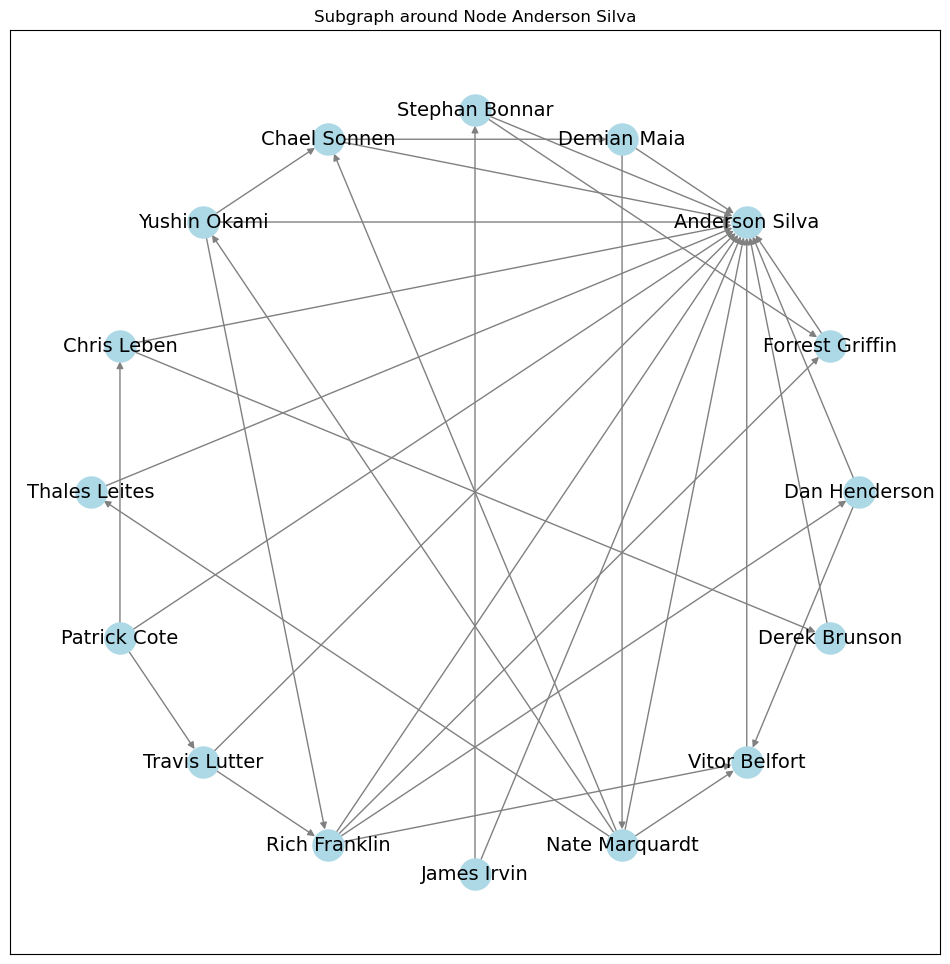

In [14]:
node = 'Anderson Silva'
radius = 1  # Number of steps to expand around the node

subgraph = nx.ego_graph(G_men.reverse(), node, radius=radius)

# Plot the subgraph
pos = nx.circular_layout(subgraph)  # Positions of nodes for visualization
plt.figure(figsize=(12, 12))
nx.draw_networkx(subgraph.reverse(), pos, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray', font_size=14)
plt.title(f"Subgraph around Node {node}")
plt.show()


In [15]:
# Create a dictionary where keys are the nodes and values are the in-degrees
in_degrees = dict(subgraph.reverse().in_degree())

# Create a dictionary where keys are the nodes and values are the out-degrees
out_degrees = dict(subgraph.reverse().out_degree())

# Combine the dictionaries into a single DataFrame
win_sub = pd.DataFrame({'NAME': list(in_degrees.keys()), 'WINS': list(in_degrees.values()), 'LOSSES': list(out_degrees.values())})
# Calculate total degrees for each node as the sum of in-degree and out-degree
win_sub['TOTAL'] = win_sub['WINS'] + win_sub['LOSSES']

# Calculate in-degree percentage
win_sub['WIN PERCENTAGE'] = (win_sub['WINS'] / win_sub['TOTAL'])

# If you want to sort the DataFrame by node name:
win_sub = win_sub.sort_values('WINS', ascending=False).reset_index(drop=True)
win_sub

,NAME,WINS,LOSSES,TOTAL,WIN PERCENTAGE
0,Anderson Silva,15,0,15,1.000000
1,Vitor Belfort,3,1,4,0.750000
2,Forrest Griffin,2,1,3,0.666667
3,Chael Sonnen,2,2,4,0.500000
4,Rich Franklin,2,4,6,0.333333
5,Dan Henderson,1,2,3,0.333333
6,Demian Maia,1,2,3,0.333333
7,Stephan Bonnar,1,2,3,0.333333
8,Yushin Okami,1,3,4,0.250000
9,Chris Leben,1,2,3,0.333333


In [16]:
#calculate pagerank for Anderson Silva's subgraph
pagerank = nx.pagerank(subgraph.reverse())
pagerank = dict(sorted(pagerank.items(), key=lambda x: x[1], reverse=True))
# Create the DataFrame 'pagerank' from the dictionary
pagerank_df = pd.DataFrame(list(pagerank.items()), columns=['NAME', 'PAGERANK'])
# Print the resulting DataFrame
pagerank_df

,NAME,PAGERANK
0,Anderson Silva,0.355054
1,Vitor Belfort,0.064865
2,Forrest Griffin,0.056810
3,Rich Franklin,0.053985
4,Nate Marquardt,0.048703
5,Demian Maia,0.048154
6,Chael Sonnen,0.046863
7,Derek Brunson,0.043638
8,Stephan Bonnar,0.040238
9,Dan Henderson,0.039709


In [17]:
# Merge 'pagerank_df' and 'nodes1' DataFrames based on the 'NAME' column
merged_df = pagerank_df.merge(win_sub, on='NAME')
merged_df

,NAME,PAGERANK,WINS,LOSSES,TOTAL,WIN PERCENTAGE
0,Anderson Silva,0.355054,15,0,15,1.000000
1,Vitor Belfort,0.064865,3,1,4,0.750000
2,Forrest Griffin,0.056810,2,1,3,0.666667
3,Rich Franklin,0.053985,2,4,6,0.333333
4,Nate Marquardt,0.048703,1,5,6,0.166667
5,Demian Maia,0.048154,1,2,3,0.333333
6,Chael Sonnen,0.046863,2,2,4,0.500000
7,Derek Brunson,0.043638,1,1,2,0.500000
8,Stephan Bonnar,0.040238,1,2,3,0.333333
9,Dan Henderson,0.039709,1,2,3,0.333333


In [18]:
# Merge 'pagerank_df' and 'nodes1' DataFrames based on the 'NAME' column
merged_df = pagerank_df.merge(win_sub, on='NAME')

# Add the new 'adjusted_pagerank' column by multiplying 'pagerank' with 'PRECENT'
merged_df['ADJUSTED PAGERANK'] = merged_df['PAGERANK'] * merged_df['WIN PERCENTAGE']

# Sort 'merged_df' by 'adjusted_pagerank' column in descending order
ranked_df = merged_df.sort_values(by='ADJUSTED PAGERANK', ascending=False)

# Reset the index of the ranked DataFrame
ranked_df.reset_index(drop=True, inplace=True)

# Print the resulting ranked DataFrame
ranked_df

,NAME,PAGERANK,WINS,LOSSES,TOTAL,WIN PERCENTAGE,ADJUSTED PAGERANK
0,Anderson Silva,0.355054,15,0,15,1.000000,0.355054
1,Vitor Belfort,0.064865,3,1,4,0.750000,0.048648
2,Forrest Griffin,0.056810,2,1,3,0.666667,0.037873
3,Chael Sonnen,0.046863,2,2,4,0.500000,0.023431
4,Derek Brunson,0.043638,1,1,2,0.500000,0.021819
5,Thales Leites,0.036516,1,1,2,0.500000,0.018258
6,Rich Franklin,0.053985,2,4,6,0.333333,0.017995
7,Demian Maia,0.048154,1,2,3,0.333333,0.016051
8,Stephan Bonnar,0.040238,1,2,3,0.333333,0.013413
9,Dan Henderson,0.039709,1,2,3,0.333333,0.013236


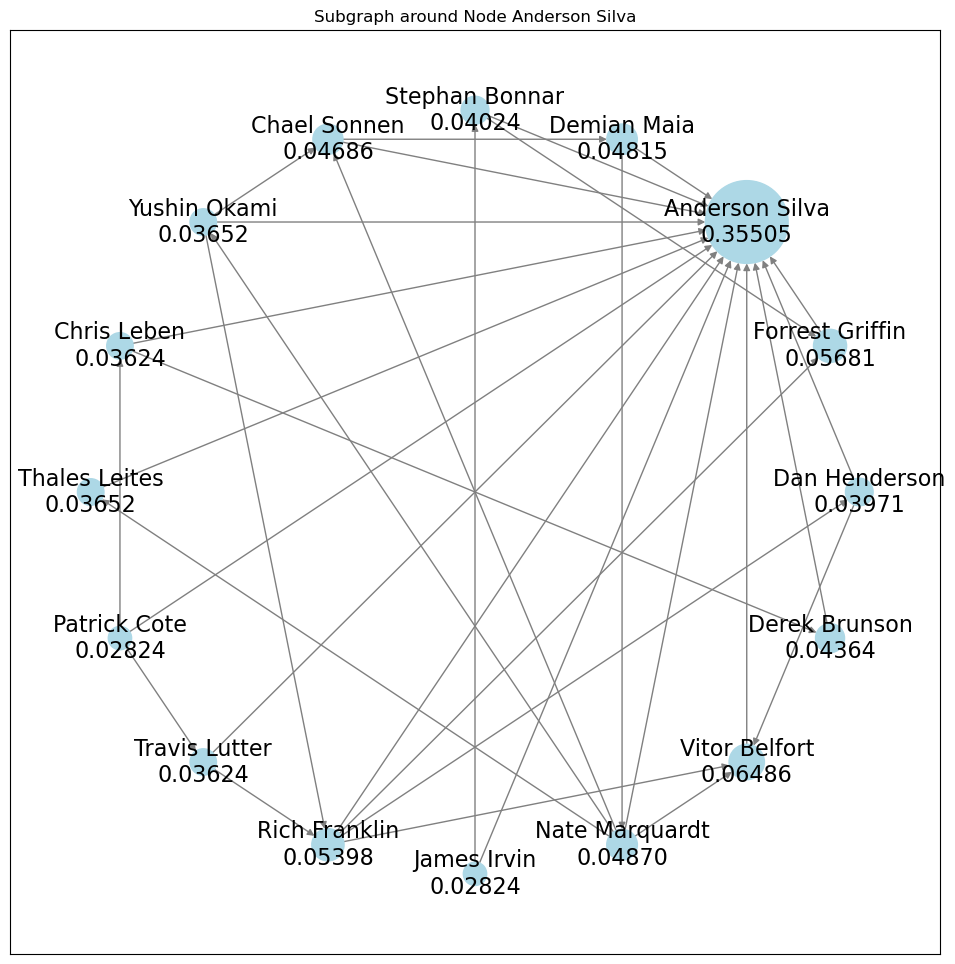

In [19]:
#Draw graph of pagerank
for index, row in pagerank_df.iterrows():
    # Set PageRank as an attribute of the node
    if row['NAME'] in G_men:
        G_men.nodes[row['NAME']]['pagerank'] = row['PAGERANK']

node = 'Anderson Silva'
radius = 1  # Number of steps to expand around the node

subgraph = nx.ego_graph(G_men.reverse(), node, radius=radius)

# Collect PageRank scores and scale them for visualization
pageranks = [10000 * subgraph.nodes[n].get('pagerank', 0) for n in subgraph.nodes()]

# Plot the subgraph
pos = nx.circular_layout(subgraph)  # Positions of nodes for visualization
plt.figure(figsize=(12, 12))
nx.draw_networkx(subgraph.reverse(), pos, with_labels=False, node_color='lightblue', node_size=pageranks, edge_color='gray')

# Draw PageRank as label
labels = nx.get_node_attributes(subgraph, 'pagerank')
for node, (x, y) in pos.items():
    plt.text(x, y, f'{node}\n{labels.get(node, 0):.5f}', ha='center', va='center', fontsize=16)

node = 'Anderson Silva'
plt.title(f"Subgraph around Node {node}")
plt.show()


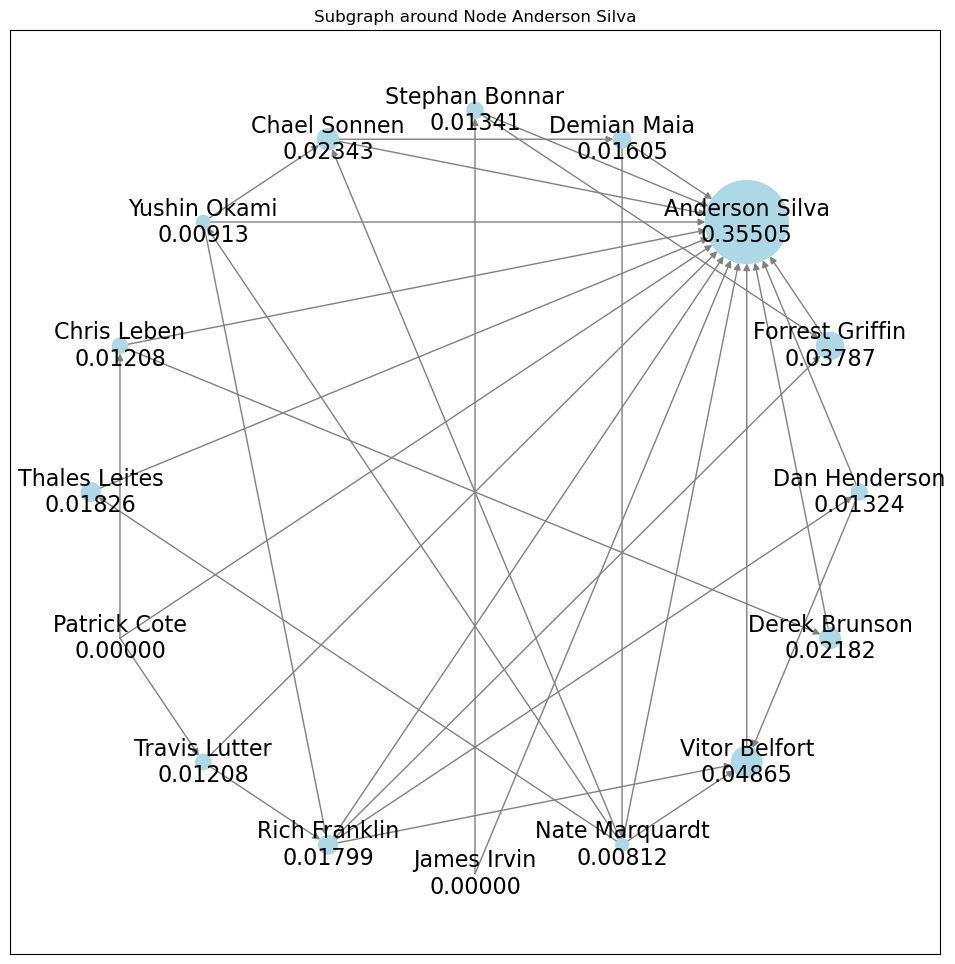

In [20]:
#Draw graph of adjusted pagerank
for index, row in ranked_df.iterrows():
    # Set PageRank as an attribute of the node
    if row['NAME'] in G_men:
        G_men.nodes[row['NAME']]['ADJUSTED PAGERANK'] = row['ADJUSTED PAGERANK']

node = 'Anderson Silva'
radius = 1  # Number of steps to expand around the node

subgraph = nx.ego_graph(G_men.reverse(), node, radius=radius)

# Collect PageRank scores and scale them for visualization
pageranks = [10000 * subgraph.nodes[n].get('ADJUSTED PAGERANK', 0) for n in subgraph.nodes()]

# Plot the subgraph
pos = nx.circular_layout(subgraph)  # Positions of nodes for visualization
plt.figure(figsize=(12, 12))
nx.draw_networkx(subgraph.reverse(), pos, with_labels=False, node_color='lightblue', node_size=pageranks, edge_color='gray')

# Draw PageRank as label
labels = nx.get_node_attributes(subgraph, 'ADJUSTED PAGERANK')
for node, (x, y) in pos.items():
    plt.text(x, y, f'{node}\n{labels.get(node, 0):.5f}', ha='center', va='center', fontsize=16)

node = 'Anderson Silva'
plt.title(f"Subgraph around Node {node}")
plt.show()

<h1>Finding the best pound-for-pound male fighters</h1>

In [21]:
#Calculating pagerank
pagerank = nx.pagerank(G_men)
pagerank = dict(sorted(pagerank.items(), key=lambda x: x[1], reverse=True))
pagerank

{'Leon Edwards': 0.008016346166311144,
 'Israel Adesanya': 0.006883183443566648,
 'Kamaru Usman': 0.006795922686917768,
 'Jon Jones': 0.0065828387929240595,
 'Matt Hamill': 0.006411800668442901,
 'Stipe Miocic': 0.0056589652656525435,
 'Islam Makhachev': 0.005518784765134724,
 'Adriano Martins': 0.00540477083778908,
 'Jan Blachowicz': 0.005300124821049758,
 'Max Holloway': 0.0052333262395612475,
 'Francis Ngannou': 0.0050464465736843106,
 'Derrick Lewis': 0.005021657538588372,
 'Donald Cerrone': 0.004996869382198634,
 'Aljamain Sterling': 0.0048889446708909046,
 'Dustin Poirier': 0.004872897390682294,
 'Matt Hughes': 0.0044402945968450075,
 'Henry Cejudo': 0.004119818693633008,
 'Raphael Assuncao': 0.0040786291774838205,
 'Junior Dos Santos': 0.003961689605617317,
 'Marlon Vera': 0.0038907996695133154,
 'Charles Oliveira': 0.0038200338932559436,
 'Alistair Overeem': 0.003788988007772709,
 'Conor McGregor': 0.003750469947235704,
 'Claudio Silva': 0.0037164860344017937,
 'Daniel Cormier'

In [22]:
# Create the DataFrame 'pagerank' from the dictionary
pagerank_df = pd.DataFrame(list(pagerank.items()), columns=['NAME', 'PAGERANK'])

# Print the resulting DataFrame
pagerank_df

,NAME,PAGERANK
0,Leon Edwards,0.008016
1,Israel Adesanya,0.006883
2,Kamaru Usman,0.006796
3,Jon Jones,0.006583
4,Matt Hamill,0.006412
...,...,...
2108,Alberta Cerra Leon,0.000085
2109,Robert Lucarelli,0.000085
2110,David Levicki,0.000085
2111,Ray Wizard,0.000085


In [23]:
pagerank_df['PAGERANK'].sum()

0.9999999999999998

In [24]:
# Create the DataFrame 'pagerank' from the dictionary
pagerank_df = pd.DataFrame(list(pagerank.items()), columns=['NAME', 'PAGERANK'])

# Print the resulting DataFrame
pagerank_df.head(15)


,NAME,PAGERANK
0,Leon Edwards,0.008016
1,Israel Adesanya,0.006883
2,Kamaru Usman,0.006796
3,Jon Jones,0.006583
4,Matt Hamill,0.006412
5,Stipe Miocic,0.005659
6,Islam Makhachev,0.005519
7,Adriano Martins,0.005405
8,Jan Blachowicz,0.005300
9,Max Holloway,0.005233


In [25]:
# Merge 'pagerank_df' and 'nodes1' DataFrames based on the 'NAME' column
merged_df = pagerank_df.merge(nodes1, on='NAME')

# Add the new 'adjusted_pagerank' column by multiplying 'pagerank' with 'PRECENT'
merged_df['ADJUSTED PAGERANK'] = merged_df['PAGERANK'] * merged_df['WIN PERCENT']/100

In [26]:
# Sort 'merged_df' by 'adjusted_pagerank' column in descending order
ranked_df = merged_df.sort_values(by='ADJUSTED PAGERANK', ascending=False)

# Reset the index of the ranked DataFrame
ranked_df.reset_index(drop=True, inplace=True)
ranked_df.index = range(1, len(ranked_df) + 1)

# Print the resulting ranked DataFrame
ranked_df.head(15)

,NAME,PAGERANK,OVERALL,WINS,WIN PERCENT,ADJUSTED PAGERANK
1,Leon Edwards,0.008016,15,13,86.666667,0.006948
2,Jon Jones,0.006583,22,21,95.454545,0.006284
3,Kamaru Usman,0.006796,17,15,88.235294,0.005996
4,Israel Adesanya,0.006883,15,13,86.666667,0.005965
5,Islam Makhachev,0.005519,14,13,92.857143,0.005125
6,Stipe Miocic,0.005659,18,14,77.777778,0.004401
7,Francis Ngannou,0.005046,14,12,85.714286,0.004326
8,Matt Hamill,0.006412,15,10,66.666667,0.004275
9,Aljamain Sterling,0.004889,18,15,83.333333,0.004074
10,Max Holloway,0.005233,27,20,74.074074,0.003877


In [27]:
#calculate ranking for 'Alexander Volkanovski', was suprised he was not in top 15
target_name = 'Alexander Volkanovski'

# Find the row(s) where the NAME column value matches the target_name
matching_rows = ranked_df[ranked_df['NAME'] == target_name]

# Print the matching row(s)
print(matching_rows)

                     NAME  PAGERANK  OVERALL  WINS  WIN PERCENT  \
22  Alexander Volkanovski  0.003145       13    12    92.307692   

    ADJUSTED PAGERANK  
22           0.002903  


<h1>Finding the best pound-for-pound female fighters</h1>

In [28]:
#Calculate pagerank for female fighters
pagerank = nx.pagerank(G_women)
pagerank = dict(sorted(pagerank.items(), key=lambda x: x[1], reverse=True))
pagerank

{'Amanda Nunes': 0.06985578310334369,
 'Julianna Pena': 0.04098329919560334,
 'Cat Zingano': 0.03228260745742432,
 'Valentina Shevchenko': 0.03197895989250136,
 'Carla Esparza': 0.02708334736474706,
 'Jessica Andrade': 0.02525371400809834,
 'Rose Namajunas': 0.02215694830566131,
 'Alexa Grasso': 0.021726991737867078,
 'Germaine de Randamie': 0.020757999707207344,
 'Holly Holm': 0.01735757836606853,
 'Raquel Pennington': 0.016814786115480672,
 'Joanna Jedrzejczyk': 0.015099339889020631,
 'Tatiana Suarez': 0.014751036800881506,
 'Ketlen Vieira': 0.013859837357343724,
 'Zhang Weili': 0.013744864495817199,
 'Marina Rodriguez': 0.012921739196527313,
 'Ronda Rousey': 0.012777463074819046,
 'Katlyn Chookagian': 0.012676910894704626,
 'Karolina Kowalkiewicz': 0.011661321737668966,
 'Yan Xiaonan': 0.01085834916058974,
 'Megan Anderson': 0.010628659638847397,
 'Claudia Gadelha': 0.009596530084771175,
 'Irene Aldana': 0.00931277022905903,
 'Randa Markos': 0.009061263841234884,
 'Amanda Lemos': 0.

In [29]:
# Create the DataFrame 'pagerank' from the dictionary
pagerank_df = pd.DataFrame(list(pagerank.items()), columns=['NAME', 'PAGERANK'])

# Print the resulting DataFrame
pagerank_df

,NAME,PAGERANK
0,Amanda Nunes,0.069856
1,Julianna Pena,0.040983
2,Cat Zingano,0.032283
3,Valentina Shevchenko,0.031979
4,Carla Esparza,0.027083
...,...,...
215,Shayna Baszler,0.000893
216,Sarah Frota,0.000893
217,Rin Nakai,0.000893
218,Liliya Shakirova,0.000893


In [30]:
pagerank_df['PAGERANK'].sum()

1.0

In [31]:
# Create the DataFrame 'pagerank' from the dictionary
pagerank_df = pd.DataFrame(list(pagerank.items()), columns=['NAME', 'PAGERANK'])

# Print the resulting DataFrame
pagerank_df.head(15)

,NAME,PAGERANK
0,Amanda Nunes,0.069856
1,Julianna Pena,0.040983
2,Cat Zingano,0.032283
3,Valentina Shevchenko,0.031979
4,Carla Esparza,0.027083
5,Jessica Andrade,0.025254
6,Rose Namajunas,0.022157
7,Alexa Grasso,0.021727
8,Germaine de Randamie,0.020758
9,Holly Holm,0.017358


In [32]:
# Merge 'pagerank_df' and 'nodes1' DataFrames based on the 'NAME' column
merged_df = pagerank_df.merge(nodes1, on='NAME')

# Add the new 'adjusted_pagerank' column by multiplying 'pagerank' with 'PRECENT'
merged_df['ADJUSTED PAGERANK'] = merged_df['PAGERANK'] * merged_df['WIN PERCENT']/100

In [33]:
# Sort 'merged_df' by 'adjusted_pagerank' column in descending order
ranked_df = merged_df.sort_values(by='ADJUSTED PAGERANK', ascending=False)

# Reset the index of the ranked DataFrame
ranked_df.reset_index(drop=True, inplace=True)
ranked_df.index = range(1, len(ranked_df) + 1)

# Print the resulting ranked DataFrame
ranked_df.head(15)

,NAME,PAGERANK,OVERALL,WINS,WIN PERCENT,ADJUSTED PAGERANK
1,Amanda Nunes,0.069856,17,15,88.235294,0.061637
2,Julianna Pena,0.040983,10,7,70.000000,0.028688
3,Valentina Shevchenko,0.031979,15,12,80.000000,0.025583
4,Carla Esparza,0.027083,15,10,66.666667,0.018056
5,Germaine de Randamie,0.020758,9,7,77.777778,0.016145
6,Alexa Grasso,0.021727,11,8,72.727273,0.015801
7,Jessica Andrade,0.025254,24,15,62.500000,0.015784
8,Rose Namajunas,0.022157,13,9,69.230769,0.015339
9,Tatiana Suarez,0.014751,6,6,100.000000,0.014751
10,Cat Zingano,0.032283,7,3,42.857143,0.013835
